Beggining training!
Epoch 1/20
289/289 [==============================] - 3s - loss: 0.3571 - acc: 0.8616     
Epoch 2/20
289/289 [==============================] - 2s - loss: 0.2432 - acc: 0.9204     
Epoch 3/20
289/289 [==============================] - 2s - loss: 0.2465 - acc: 0.9066     
Epoch 4/20
289/289 [==============================] - 2s - loss: 0.2307 - acc: 0.9031     
Epoch 5/20
289/289 [==============================] - 2s - loss: 0.2089 - acc: 0.9170     
Epoch 6/20
289/289 [==============================] - 2s - loss: 0.1966 - acc: 0.9135     
Epoch 7/20
289/289 [==============================] - 2s - loss: 0.1945 - acc: 0.9031     
Epoch 8/20
289/289 [==============================] - 2s - loss: 0.1886 - acc: 0.9170     
Epoch 9/20
289/289 [==============================] - 2s - loss: 0.1663 - acc: 0.9100     
Epoch 10/20
289/289 [==============================] - 2s - loss: 0.1671 - acc: 0.9204     - ETA: 1s - loss: 0.1782 - acc
Epoch 11/20
289/289 [==================

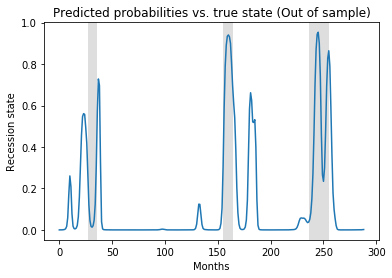

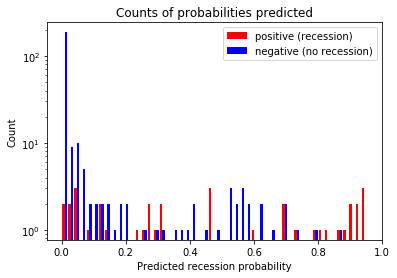

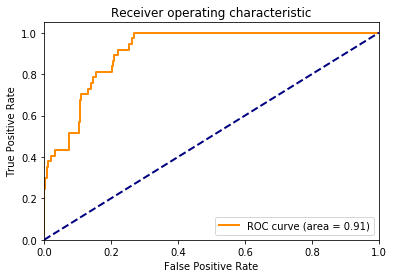

In [13]:
#imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import h5py
import math
import os.path
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

#class that creates a singular LSTM with given parameters
class Prediction:
    
    ##Constructor##
    def __init__(self, n_hidden, n_batch_size, n_epochs, 
                 n_dropout, d_horizon, d_timesteps, 
                 d_test_samples, d_parameter_list, d_shuffled, 
                 data_x, data_y):
        #the size of the hidden layer
        self.n_hidden = n_hidden
        
        #the batch size used in training
        self.n_batch_size = n_batch_size
        
        #the number of training epochs
        self.n_epochs = n_epochs
        
        #the dropout rate during training
        self.n_dropout = n_dropout
        
        #the number of months in the future for which a recession prediction is to be made
        self.d_horizon = d_horizon
        
        #the number of months of data comprising a case
        self.d_timesteps = d_timesteps
        
        #the proportion of the data set to be used as the test data
        self.d_test_samples = d_test_samples
        
        #the specified market variables with which the LSTM will train and test with
        self.d_parameter_list = d_parameter_list
        
        #indicates whether or not the LSTM will be trained with data that is randomly sampled from the complete data set
        self.d_shuffled = d_shuffled
        
        #the initial raw market variable data set
        self.data_x = data_x
        
        #the initial raw recession state data set
        self.data_y = data_y.astype('float32')
        
        #prepare the data sets for training and testing
        self.filter_data()
        self.create_datasets()
        
    #The indices for each market variable in the raw data set
    # 0: SP500
    # 1: 10Y Rate - 3M TBill
    # 2: 10Y Rate
    # 3: 3M TBill
    # 4: 3M TBill - FF
    # 5: 6M TBill - FF
    # 6: 1Y Rate - FF
    # 7: 5Y Rate - FF
    # 8: 10Y Rate - FF
    # 9: Composite Leading Indicator
    # 10: Recession State
    
    ##Filters the market variable data set to only contain the variables specified by the parameter list##
    def filter_data(self):
        #index and coloums for the dataframe
        row = pd.date_range('1963-01-01', '2012-02-01', freq='M', name='Date')
        column = np.array(['SP500', '10Y Rate - 3M TBill', '10Y Rate', 
                           '3M TBill', '3M TBill - FF', '6M TBill - FF', 
                           '1Y Rate - FF', '5Y Rate - FF', '10Y Rate - FF', 
                           'Composite Leading Indicator', 'Recession State'])
        
        data_x_filtered = pd.DataFrame(
            self.data_x.values[:, self.d_parameter_list], 
            index=row, columns=column[self.d_parameter_list])
        
        self.data_x = data_x_filtered

    def create_datasets(self):
        #the dimensions of the input and output fed into and retrieved from the LSTM
        inputDim = len(self.data_x.values[0])
        outputDim = len(self.data_y.values[0])
        
        #modifies the x dataset into the shape (case, timestep, input value)
        self.data_x_mod = np.array([[self.data_x.values[timestep] for timestep in np.arange(case, case + self.d_timesteps)] for case in np.arange(len(self.data_x.values) - self.d_timesteps + 1)])
        #modifies the y dataset into the shape (case, output value)
        self.data_y_mod = np.array(self.data_y.values[self.d_horizon + self.d_timesteps - 1: len(self.data_x.values) + self.d_horizon])

        #the index at which the datasets are split into training and testing sets
        split_index = int(len(self.data_x_mod) * self.d_test_samples)
        
        #the row indices for the recession state datafram split for training and testing sets
        rng_y = self.data_y.index[self.d_horizon + self.d_timesteps - 1: len(self.data_x.values) + self.d_horizon]
        rng_train_y = rng_y[:split_index]
        rng_test_y = rng_y[split_index:]

        #shuffles random samples of data for both training and testing sets if required
        train_x = self.data_x_mod[:split_index]
        train_y = self.data_y_mod[:split_index]

        test_x = self.data_x_mod[split_index:]
        test_y = self.data_y_mod[split_index:]
        if (self.d_shuffled == True):
            data_x_shuffled, data_y_shuffled = self.unison_shuffled_copies(self.data_x_mod, self.data_y_mod)
            train_x = data_x_shuffled[:split_index]
            train_y = data_y_shuffled[:split_index]

            test_x = data_x_shuffled[split_index:]
            test_y = data_y_shuffled[split_index:]
        
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.rng_train_y = rng_train_y
        self.rng_test_y = rng_test_y
        
    ##Shuffles two vectors in unison, where each paired index stays paired. Only their paired positions change##
    def unison_shuffled_copies(selfm, a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    ##Initiates and trains an LSTM with given parameters##
    def train_LSTM(self):
        #initiate LSTM
        #two hidden layers are used
        self.model = Sequential()
        self.model.add(LSTM(
            self.n_hidden, 
            input_shape=(self.d_timesteps, len(self.d_parameter_list)), 
            return_sequences=True))
        self.model.add(Dropout(self.n_dropout))
        self.model.add(LSTM(self.n_hidden, return_sequences=False))
        self.model.add(Dropout(self.n_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        print("Beggining training!")
        
        #train LSTM
        self.model.fit(self.train_x, self.train_y, 
                       epochs=self.n_epochs, batch_size=self.n_batch_size, verbose=1)
        print("")
    
    ##Evaluates the ROC and ROC area for the trained LSTM##
    def evaluate_LSTM(self):
        print("Evaluating!")
        
        if (self.d_shuffled):
            self.e_prediction_mod = self.model.predict(self.data_x_mod, batch_size=1, verbose=0)
        
        #evaluates the test data
        self.e_prediction = self.model.predict(self.test_x, batch_size=1, verbose=0)
        self.e_positive_negative = [
            [self.e_prediction[i, 0] for i in range(len(self.test_y)) if self.test_y[i, 0] == 1], 
            [self.e_prediction[i, 0] for i in range(len(self.test_y)) if self.test_y[i, 0] == 0]]
        self.e_fpr, self.e_tpr, self.e_threshold = metrics.roc_curve(self.test_y, self.e_prediction)
        self.e_roc_auc = metrics.auc(self.e_fpr, self.e_tpr)
        
    ##modifies plot##
    def add_bars(self, data):
        start = 0
        end = 0
        for i, prediction in enumerate(data):
            if (prediction[0] == 1):
                if (i == 0):
                    start = i
                elif (i == len(data) - 1):
                    if (data[i - 1, 0] != 1):
                        start = i
                        end = i + 1
                        plt.axvspan(start, end, color='0.75', alpha=0.5, lw=0)
                    else:
                        end = i + 1
                        plt.axvspan(start, end, color='0.75', alpha=0.5, lw=0)
                elif (data[i - 1, 0] != 1):
                    start = i
        
            if (prediction[0] == 0):
                if (data[i - 1, 0] == 1):
                    end = i
                    plt.axvspan(start, end, color='0.75', alpha=0.5, lw=0)
                    
    ##Displays the evaluations on the test data    
    def display_results(self):
        print("Parameters")
        print("Horizon: " + str(self.d_horizon))
        print("Timesteps: " + str(self.d_timesteps))
        print("Variables: " + str(self.d_parameter_list))
        print("Hidden layer size: " + str(self.n_hidden))
        print("Batch Size: " + str(self.n_batch_size))
        print("Epochs: " + str(self.n_epochs))
        
        plt.figure(1)
        if (not self.d_shuffled):
            plt.title('Predicted probabilities vs. true state (Out of sample)')
            plt.plot(self.e_prediction)
            self.add_bars(self.test_y)
        
        else:
            plt.title('Predicted probabilities vs true state (In and out of sample)')
            plt.plot(self.e_prediction_mod)
            self.add_bars(self.data_y_mod)
            
        plt.xlabel("Months")
        plt.ylabel("Recession state")
        
        plt.figure(2)
        plt.title('Counts of probabilities predicted')
        plt.hist(
            self.e_positive_negative, 50, 
            histtype='bar', color=['red', 'blue'], 
            label=['positive (recession)', 'negative (no recession)'], 
            log=True)
        plt.xlabel("Predicted recession probability")
        plt.ylabel("Count")
        plt.legend()
        
        plt.figure(3)
        plt.title('Receiver operating characteristic')
        lw = 2
        plt.plot(self.e_fpr, self.e_tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % self.e_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        
        plt.show()
 
    ##saves trained LSTM data to local folder##
    def save_LSTM(self, path):
        self.model.save(path)
    
    ##loads local LSTM data##
    def load_LSTM(self, path):
        self.model = load_model(path)

        
def parse_data():
    #read in data
    data_x_raw = pd.read_csv('leading_indicators.csv')
    data_y_raw = pd.read_csv('recession_state.csv')

    #create row and column headers
    rng_x = pd.date_range('1963-01-01', '2012-02-01', freq='M', name='Date')
    rng_y = pd.date_range('1963-01-01', '2014-02-01', freq='M', name='Date')
    column = np.array(['SP500', '10Y Rate - 3M TBill', '10Y Rate', 
                       '3M TBill', '3M TBill - FF', '6M TBill - FF', 
                       '1Y Rate - FF', '5Y Rate - FF', '10Y Rate - FF', 
                       'Composite Leading Indicator', 'Recession State'])

    #filter values
    data_x_values = np.array(data_x_raw.values)
    data_y_values = np.array(data_y_raw.values)
    data_x_values = np.delete(data_x_values, (0), axis=1)
    data_y_values = np.delete(data_y_values, (0), axis=1)

    #create filtered dataframe
    data_x = pd.DataFrame(data_x_values, index=rng_x, columns=column[:10])
    data_y = pd.DataFrame(data_y_values, index=rng_y, columns=[column[10]])

    return data_x, data_y 
    #list of predictions

if __name__ == "__main__":
    data_x, data_y = parse_data()
    pred = Prediction(300, 20, 20, 0.2, 3, 12, .5, [0, 1, 6], False, data_x, data_y,)
    pred.train_LSTM()
    pred.evaluate_LSTM()
    pred.display_results()
    print("hey")